#  Forecast for COVID-19 cases and fatalities


This project is a part of the kaggle competition https://www.kaggle.com/c/covid19-global-forecasting-week-2 . The goal is to predict cases and fatalities of COVID-19

First step as usual is to import packages

In [1]:
import pandas as pd
import numpy as np
import sklearn #For modelling
import matplotlib.pyplot as plt #For plots
import pmdarima as pmd #For ARIMA modles

Read in data which is a time series with amount of total COVID-19 cases by country and total fatalities for each country. The plan is to predict future cases and fatalities for each country.  We are also using another dataset which is available on https://www.kaggle.com/koryto/countryinfo which has various information for each country. 

In [2]:
import warnings;
warnings.filterwarnings('ignore');

In [3]:
trainingData = pd.read_csv("~/CovidData/train.csv")


In [4]:
testingData = pd.read_csv("~/CovidData/test.csv")

In [5]:
mergeData = pd.read_csv("~/CovidData/covid19countryinfo.csv")

Check out the datasets and get familiar with them

In [6]:
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 60 columns):
region            74 non-null object
country           249 non-null object
alpha3code        191 non-null object
alpha2code        191 non-null object
pop               187 non-null object
tests             52 non-null float64
testpop           52 non-null float64
density           187 non-null float64
medianage         187 non-null float64
urbanpop          187 non-null float64
quarantine        64 non-null object
schools           78 non-null object
publicplace       58 non-null object
gatheringlimit    32 non-null float64
gathering         32 non-null object
nonessential      16 non-null object
hospibed          186 non-null float64
smokers           123 non-null float64
sex0              187 non-null float64
sex14             187 non-null float64
sex25             187 non-null float64
sex54             187 non-null float64
sex64             187 non-null float64
sex65plus        

In [7]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 6 columns):
Id                20580 non-null int64
Province_State    8750 non-null object
Country_Region    20580 non-null object
Date              20580 non-null object
ConfirmedCases    20580 non-null float64
Fatalities        20580 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 964.8+ KB


In [8]:
testingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12642 entries, 0 to 12641
Data columns (total 4 columns):
ForecastId        12642 non-null int64
Province_State    5375 non-null object
Country_Region    12642 non-null object
Date              12642 non-null object
dtypes: int64(1), object(3)
memory usage: 395.2+ KB


# Data exploration

Lets check out the external data further. We notice that there is not much data available from regions. The data is mostly available for whole countries

In [9]:
mergeData.tail(10)

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,...,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m
239,Tennessee,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,Texas,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,Utah,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,Vermont,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,Virginia,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,Washington,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,Washington DC,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,West Virginia,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,Wisconsin,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,Wyoming,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
mergeData.head(10)

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,...,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m
0,NaN,Afghanistan,AFG,AF,"38,928,346",NaN,NaN,60.0,18.0,25.0,...,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,7,0.2
1,NaN,Albania,ALB,AL,"2,877,797",NaN,NaN,105.0,36.0,63.0,...,1.0,NaN,89,7,8,7,7,7,106,6.0
2,NaN,Algeria,DZA,DZ,"43,851,044",NaN,NaN,18.0,29.0,73.0,...,NaN,NaN,61,NaN,NaN,NaN,NaN,NaN,22,2.0
3,NaN,Andorra,AND,AD,"77,265",NaN,NaN,164.0,45.0,88.0,...,1.0,1.0,16,10,10,12,12,12,"5,682",207.0
4,NaN,Antigua and Barbuda,ATG,AG,"97,929",NaN,NaN,223.0,34.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,NaN
5,NaN,Argentina,ARG,AR,"45,195,774",NaN,NaN,17.0,32.0,93.0,...,2.0,3.0,256,NaN,NaN,NaN,NaN,NaN,28,0.9
6,NaN,Armenia,ARM,AM,"2,963,243",694.0,4269.802594,104.0,35.0,63.0,...,1.0,NaN,43,15,30,30,30,30,248,2.0
7,Aruba,Netherlands,ABW,AW,"106,766",NaN,NaN,593.0,41.0,44.0,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,562,NaN
8,NaN,Australia,AUS,AU,"25,499,884",31635.0,806.065560,3.0,38.0,86.0,...,2.0,3.0,585,28,28,50,50,85,210,1.0
9,NaN,Austria,AUT,AT,"9,006,398",10278.0,876.279237,109.0,43.0,57.0,...,12.0,10.0,"2,022",193,198,215,227,245,"1,271",19.0


We filter the region data out of this dataset since it does not hold much information and would complicate things.

In [11]:
mergeData = mergeData[(mergeData['region'].isnull())]

We pick some variables from which would be interesting to use and have few missing values. We will add these to the main dataset and check out which of those featuers are important in predicting number of cases and fatalities. The variables chosen are population statistics, health and weather statistics. Population statistics to check if population and population density affects spread. Health statistics to check if countries with better healthcare/healthier people affect spread and weather statistics to check if difference in weather affects spread. All things that has been discussed in the media as a potential factor for increased spread of COVID-19.

In [12]:
dataToMerge = mergeData[['country','pop','density','medianage','hospibed','gdp2019', 'urbanpop', 'healthperpop', 'healthexp','lung','malelung','femalelung','avgtemp','avghumidity' ]]

In [13]:
dataToMerge['Country_Region'] = dataToMerge['country']

In [14]:
dataToMerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 192
Data columns (total 15 columns):
country           175 non-null object
pop               175 non-null object
density           175 non-null float64
medianage         175 non-null float64
hospibed          175 non-null float64
gdp2019           174 non-null object
urbanpop          175 non-null float64
healthperpop      173 non-null float64
healthexp         170 non-null object
lung              163 non-null float64
malelung          163 non-null float64
femalelung        163 non-null float64
avgtemp           145 non-null float64
avghumidity       145 non-null float64
Country_Region    175 non-null object
dtypes: float64(10), object(5)
memory usage: 21.9+ KB


In [15]:
dataToMerge.head()

,country,pop,density,medianage,hospibed,gdp2019,urbanpop,healthperpop,healthexp,lung,malelung,femalelung,avgtemp,avghumidity,Country_Region
0,Afghanistan,"38,928,346",60.0,18.0,0.5,"18,734",25.0,4.726633,184,37.62,39.33,36.31,6.216667,56.933333,Afghanistan
1,Albania,"2,877,797",105.0,36.0,2.9,"15,418",63.0,268.955733,774,11.67,17.04,7.02,13.950000,69.900000,Albania
2,Algeria,"43,851,044",18.0,29.0,1.9,"172,781",73.0,23.511413,"1,031",8.77,12.81,5.03,19.566667,61.716667,Algeria
3,Andorra,"77,265",164.0,45.0,2.5,"91,527",88.0,76994.758300,"5,949",NaN,NaN,NaN,7.383333,75.233333,Andorra
4,Antigua and Barbuda,"97,929",223.0,34.0,3.8,"1,688",26.0,11283.685120,"1,105",11.76,18.78,7.67,NaN,NaN,Antigua and Barbuda


We merge the data together. Combining the data on cases and fatalities of each region and the external data.

In [16]:
mergedTrain = pd.merge(trainingData,dataToMerge,how ='left',on = ['Country_Region'])
mergedTest = pd.merge(testingData,dataToMerge,how ='left',on = ['Country_Region'])

In [17]:
mergedTrain =mergedTrain.drop(['country'],axis =1)
mergedTest =mergedTest.drop(['country'],axis =1)

In [18]:
mergedTrain.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,pop,density,medianage,hospibed,gdp2019,urbanpop,healthperpop,healthexp,lung,malelung,femalelung,avgtemp,avghumidity
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,"38,928,346",60.0,18.0,0.5,"18,734",25.0,4.726633,184,37.62,39.33,36.31,6.216667,56.933333
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,"38,928,346",60.0,18.0,0.5,"18,734",25.0,4.726633,184,37.62,39.33,36.31,6.216667,56.933333
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,"38,928,346",60.0,18.0,0.5,"18,734",25.0,4.726633,184,37.62,39.33,36.31,6.216667,56.933333
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,"38,928,346",60.0,18.0,0.5,"18,734",25.0,4.726633,184,37.62,39.33,36.31,6.216667,56.933333
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,"38,928,346",60.0,18.0,0.5,"18,734",25.0,4.726633,184,37.62,39.33,36.31,6.216667,56.933333


In [19]:
mergedTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20580 entries, 0 to 20579
Data columns (total 19 columns):
Id                20580 non-null int64
Province_State    8750 non-null object
Country_Region    20580 non-null object
Date              20580 non-null object
ConfirmedCases    20580 non-null float64
Fatalities        20580 non-null float64
pop               20440 non-null object
density           20440 non-null float64
medianage         20440 non-null float64
hospibed          20440 non-null float64
gdp2019           20370 non-null object
urbanpop          20440 non-null float64
healthperpop      20300 non-null float64
healthexp         20230 non-null object
lung              19810 non-null float64
malelung          19810 non-null float64
femalelung        19810 non-null float64
avgtemp           18410 non-null float64
avghumidity       18410 non-null float64
dtypes: float64(12), int64(1), object(6)
memory usage: 3.1+ MB


There are some missing values for province state in the dataset it seems to be that for some countries the data on which state is not available. Lets fill up those missing values with a seperate category. There are also some missing values for the external data and some variables wrongly formatted

In [20]:
mergedTrain['Province_State'] = mergedTrain['Province_State'] .fillna('NA')
mergedTest['Province_State'] = mergedTest['Province_State'] .fillna('NA')
    

In [21]:
test2 = mergedTrain.loc[mergedTrain['gdp2019'].isnull()]

In [22]:
test2['Country_Region'].unique()

array(['Angola', 'Diamond Princess', 'Papua New Guinea'], dtype=object)

Angola, Diamond Princess and Papua New Guinea had missing population and gdp statistics. We fill that in manually where we can and fill with median for rest. Diamond princess is not a country but a ship with many nationalities so it is reasonable to fill diamond princess gdp in with the median. For the rest of the missing values I found no information so I decided to fill them in with the mean.

In [23]:
mergedTrain.loc[mergedTrain['Country_Region'] == 'Angola','pop'] = 25789024
mergedTrain.loc[mergedTrain['Country_Region'] == 'Papua New Guinea','pop'] = 8606323

mergedTrain.loc[mergedTrain['Country_Region'] == 'Angola','density'] = 21
mergedTrain.loc[mergedTrain['Country_Region'] == 'Papua New Guinea','density'] = 15

mergedTrain.loc[mergedTrain['Country_Region'] == 'Angola','gdp2019'] = 124600 
mergedTrain.loc[mergedTrain['Country_Region'] == 'Papua New Guinea','gdp2019'] = 21543

mergedTest.loc[mergedTest['Country_Region'] == 'Angola','pop'] = 25789024
mergedTest.loc[mergedTest['Country_Region'] == 'Papua New Guinea','pop'] = 8606323

mergedTest.loc[mergedTest['Country_Region'] == 'Angola','density'] = 21
mergedTest.loc[mergedTest['Country_Region'] == 'Papua New Guinea','density'] = 15

mergedTest.loc[mergedTest['Country_Region'] == 'Angola','gdp2019'] = 124600 
mergedTest.loc[mergedTest['Country_Region'] == 'Papua New Guinea','gdp2019'] = 21543

Some variables were formatted incorrectly as an object instead of a number. We will fix that by cutting out the commas and converting to a number.

In [24]:
mergedTrain['pop'] = mergedTrain['pop'].str.replace(',', '')
mergedTrain['gdp2019'] = mergedTrain['gdp2019'].str.replace(',', '')
mergedTrain['healthexp'] = mergedTrain['healthexp'].str.replace(',', '')

mergedTest['pop'] = mergedTest['pop'].str.replace(',', '')
mergedTest['gdp2019'] = mergedTest['gdp2019'].str.replace(',', '')
mergedTest['healthexp'] = mergedTest['healthexp'].str.replace(',', '')

In [25]:
mergedTrain['gdp2019'] = mergedTrain['gdp2019'].astype(float)
mergedTrain['pop'] = mergedTrain['pop'].astype(float)
mergedTrain['healthexp'] = mergedTrain['healthexp'].astype(float)

mergedTest['gdp2019'] = mergedTest['gdp2019'].astype(float)
mergedTest['pop'] = mergedTest['pop'].astype(float)
mergedTest['healthexp'] = mergedTest['healthexp'].astype(float)


Rest of missing data is filled with mean.

In [27]:
missingData = mergedTrain.columns[mergedTrain.isnull().any()].tolist()

missingDataset = mergedTrain[missingData]
    
for col in (missingDataset):
    mergedTrain[col].fillna(value=mergedTrain[col].median(), inplace=True)
    
for col in (missingDataset):
    mergedTest[col].fillna(value=mergedTest[col].median(), inplace=True)

Lets take a look over the data to see if everythings alright. The date will be analysed further. Instead of using the date we will make a new variable which represents number of days since data was first collected for each country.

In [28]:
mergedTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20580 entries, 0 to 20579
Data columns (total 19 columns):
Id                20580 non-null int64
Province_State    20580 non-null object
Country_Region    20580 non-null object
Date              20580 non-null object
ConfirmedCases    20580 non-null float64
Fatalities        20580 non-null float64
pop               20580 non-null float64
density           20580 non-null float64
medianage         20580 non-null float64
hospibed          20580 non-null float64
gdp2019           20580 non-null float64
urbanpop          20580 non-null float64
healthperpop      20580 non-null float64
healthexp         20580 non-null float64
lung              20580 non-null float64
malelung          20580 non-null float64
femalelung        20580 non-null float64
avgtemp           20580 non-null float64
avghumidity       20580 non-null float64
dtypes: float64(15), int64(1), object(3)
memory usage: 3.1+ MB


In [29]:
mergedTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12642 entries, 0 to 12641
Data columns (total 17 columns):
ForecastId        12642 non-null int64
Province_State    12642 non-null object
Country_Region    12642 non-null object
Date              12642 non-null object
pop               12642 non-null float64
density           12642 non-null float64
medianage         12642 non-null float64
hospibed          12642 non-null float64
gdp2019           12642 non-null float64
urbanpop          12642 non-null float64
healthperpop      12642 non-null float64
healthexp         12642 non-null float64
lung              12642 non-null float64
malelung          12642 non-null float64
femalelung        12642 non-null float64
avgtemp           12642 non-null float64
avghumidity       12642 non-null float64
dtypes: float64(13), int64(1), object(3)
memory usage: 1.7+ MB


In [30]:
mergedTrain.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,pop,density,medianage,hospibed,gdp2019,urbanpop,healthperpop,healthexp,lung,malelung,femalelung,avgtemp,avghumidity
0,1,NA,Afghanistan,2020-01-22,0.0,0.0,38928346.0,60.0,18.0,0.5,18734.0,25.0,4.726633,184.0,37.62,39.33,36.31,6.216667,56.933333
1,2,NA,Afghanistan,2020-01-23,0.0,0.0,38928346.0,60.0,18.0,0.5,18734.0,25.0,4.726633,184.0,37.62,39.33,36.31,6.216667,56.933333
2,3,NA,Afghanistan,2020-01-24,0.0,0.0,38928346.0,60.0,18.0,0.5,18734.0,25.0,4.726633,184.0,37.62,39.33,36.31,6.216667,56.933333
3,4,NA,Afghanistan,2020-01-25,0.0,0.0,38928346.0,60.0,18.0,0.5,18734.0,25.0,4.726633,184.0,37.62,39.33,36.31,6.216667,56.933333
4,5,NA,Afghanistan,2020-01-26,0.0,0.0,38928346.0,60.0,18.0,0.5,18734.0,25.0,4.726633,184.0,37.62,39.33,36.31,6.216667,56.933333


Convert date to a datetime object so we can make a new variable which counts the number of days from start of the data collection and end for each country.

In [31]:
mergedTrain['Date'] = pd.to_datetime(mergedTrain['Date'])
mergedTest['Date'] = pd.to_datetime(mergedTest['Date'])

In [32]:
mergedTrain['DayFromStart'] = mergedTrain['Date'].dt.dayofyear- min(mergedTrain['Date'].dt.dayofyear)
mergedTest['DayFromStart'] = mergedTest['Date'].dt.dayofyear -min(mergedTrain['Date'].dt.dayofyear)

In [33]:
mergedTrain = mergedTrain.drop(['Date'], axis =1)
mergedTest = mergedTest.drop(['Date'], axis =1)

In [34]:
mergedTrain.tail()

,Id,Province_State,Country_Region,ConfirmedCases,Fatalities,pop,density,medianage,hospibed,gdp2019,urbanpop,healthperpop,healthexp,lung,malelung,femalelung,avgtemp,avghumidity,DayFromStart
20575,29366,NA,Zimbabwe,5.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,65
20576,29367,NA,Zimbabwe,7.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,66
20577,29368,NA,Zimbabwe,7.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,67
20578,29369,NA,Zimbabwe,7.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,68
20579,29370,NA,Zimbabwe,8.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,69


Make copy of dataset and encode categorical features with numbers

In [35]:
trainData = mergedTrain.copy()
testData = mergedTest.copy()

In [36]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

In [37]:
trainData['Country_Region'] = encoder.fit_transform(trainData['Country_Region'])
trainData['Province_State'] = encoder.fit_transform(trainData['Province_State'])

testData['Country_Region'] = encoder.fit_transform(testData['Country_Region'])
testData['Province_State'] = encoder.fit_transform(testData['Province_State'])

In [38]:
trainData.tail()

,Id,Province_State,Country_Region,ConfirmedCases,Fatalities,pop,density,medianage,hospibed,gdp2019,urbanpop,healthperpop,healthexp,lung,malelung,femalelung,avgtemp,avghumidity,DayFromStart
20575,29366,68,172,5.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,65
20576,29367,68,172,7.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,66
20577,29368,68,172,7.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,67
20578,29369,68,172,7.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,68
20579,29370,68,172,8.0,1.0,14862924.0,38.0,18.7,1.7,12818.0,38.4,12.245235,182.0,22.53,26.47,19.31,13.75,73.4,69


In our dataset we want to mark where we start measuring from day 1. Because we have countries and some countries have subsets with different regions. So we will add a variable that indicates we are starting measuring from day 1 again. We know that the trainingset has 70 measurements for cases and deaths so that means we have 294 different places for  the measurement. Using for loops we will fill in a variable which indicates a change in a place of measurement.

In [39]:
#Find how many different places we have measurements
20580/70

294.0

In [40]:
trainData['regionChange'] = 0;
index = 0;
counter = 0;
for i in range(294):
    for j in range(70): 
        trainData['regionChange'][counter] = i
        if(j != 69):
            counter = counter+1
        j=j+1
       
    i=i+1
    counter = counter+1



Do same for test data for test data we have 43 different measurements.

In [41]:
testData['regionChange'] = 0;
index = 0;
counter = 0;
for i in range(294):
    for j in range(43): 
        testData['regionChange'][counter] = i
        if(j != 42):
            counter = counter+1
        j=j+1
    i=i+1
    counter = counter+1

lets take one last look at the dataset. Everything seems good, no missing values and all variables seem to be formatted correctly

In [42]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20580 entries, 0 to 20579
Data columns (total 20 columns):
Id                20580 non-null int64
Province_State    20580 non-null int32
Country_Region    20580 non-null int32
ConfirmedCases    20580 non-null float64
Fatalities        20580 non-null float64
pop               20580 non-null float64
density           20580 non-null float64
medianage         20580 non-null float64
hospibed          20580 non-null float64
gdp2019           20580 non-null float64
urbanpop          20580 non-null float64
healthperpop      20580 non-null float64
healthexp         20580 non-null float64
lung              20580 non-null float64
malelung          20580 non-null float64
femalelung        20580 non-null float64
avgtemp           20580 non-null float64
avghumidity       20580 non-null float64
DayFromStart      20580 non-null int64
regionChange      20580 non-null int64
dtypes: float64(15), int32(2), int64(3)
memory usage: 3.8 MB


In [43]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12642 entries, 0 to 12641
Data columns (total 18 columns):
ForecastId        12642 non-null int64
Province_State    12642 non-null int32
Country_Region    12642 non-null int32
pop               12642 non-null float64
density           12642 non-null float64
medianage         12642 non-null float64
hospibed          12642 non-null float64
gdp2019           12642 non-null float64
urbanpop          12642 non-null float64
healthperpop      12642 non-null float64
healthexp         12642 non-null float64
lung              12642 non-null float64
malelung          12642 non-null float64
femalelung        12642 non-null float64
avgtemp           12642 non-null float64
avghumidity       12642 non-null float64
DayFromStart      12642 non-null int64
regionChange      12642 non-null int64
dtypes: float64(13), int32(2), int64(3)
memory usage: 2.4 MB


Before fitting the model we will explore which variables are important in predicting for cases and fatalities using random forest feature importance. 

In [44]:
predictors = trainData.copy()
targets = trainData[['ConfirmedCases','Fatalities']]
predictors = predictors.drop(['ConfirmedCases','Fatalities', 'Id'],axis = 1)

In [95]:
from sklearn.ensemble import RandomForestRegressor
featLabels = predictors.columns

ranFor = RandomForestRegressor(n_estimators=500, random_state=190030150, n_jobs=-1)

ranFor.fit(predictors, targets)
featImp = ranFor.feature_importances_

In [96]:
indices = np.argsort(featImp)[::-1]
indices
for f in range(predictors.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,featLabels[indices[f]], featImp[indices[f]]))

 1) Province_State                 0.262383
 2) regionChange                   0.193259
 3) DayFromStart                   0.175602
 4) pop                            0.092237
 5) gdp2019                        0.080680
 6) medianage                      0.070779
 7) urbanpop                       0.024184
 8) avgtemp                        0.020799
 9) malelung                       0.015975
10) healthperpop                   0.011616
11) hospibed                       0.010415
12) avghumidity                    0.010406
13) lung                           0.007876
14) density                        0.006872
15) healthexp                      0.006149
16) Country_Region                 0.005428
17) femalelung                     0.005340


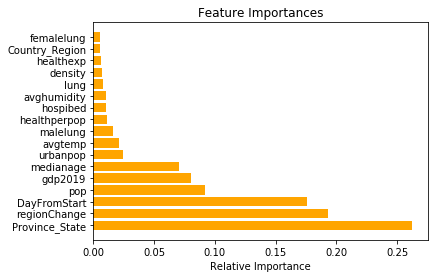

In [192]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), featImp[indices], color='orange', align='center')
plt.yticks(range(len(indices)), [featLabels[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Not all variables are important in predicting the response but we will keep them since it wont hurt to have more information.

Before fitting the model we will get dummy variables for the categorical variables which are province/region and the created variable measureChange.

In [45]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20580 entries, 0 to 20579
Data columns (total 20 columns):
Id                20580 non-null int64
Province_State    20580 non-null int32
Country_Region    20580 non-null int32
ConfirmedCases    20580 non-null float64
Fatalities        20580 non-null float64
pop               20580 non-null float64
density           20580 non-null float64
medianage         20580 non-null float64
hospibed          20580 non-null float64
gdp2019           20580 non-null float64
urbanpop          20580 non-null float64
healthperpop      20580 non-null float64
healthexp         20580 non-null float64
lung              20580 non-null float64
malelung          20580 non-null float64
femalelung        20580 non-null float64
avgtemp           20580 non-null float64
avghumidity       20580 non-null float64
DayFromStart      20580 non-null int64
regionChange      20580 non-null int64
dtypes: float64(15), int32(2), int64(3)
memory usage: 3.8 MB


In [46]:
regionDummies = pd.get_dummies(trainData['Province_State'])
measureChangeDummies = pd.get_dummies(trainData['regionChange'])
countryDummies = pd.get_dummies(trainData['Country_Region'])


regionTestDummies = pd.get_dummies(testData['Province_State'])
measureTestChangeDummies = pd.get_dummies(testData['regionChange'])
countryTestDummies = pd.get_dummies(trainData['Country_Region'])

In [47]:
trainDataCleaned = pd.concat([trainData,regionDummies],axis = 1)
trainDataCleaned = pd.concat([trainDataCleaned,measureChangeDummies],axis = 1)
trainDataCleaned = pd.concat([trainDataCleaned,countryDummies],axis = 1)

testDataCleaned = pd.concat([testData,regionTestDummies],axis = 1)
testDataCleaned = pd.concat([testDataCleaned,measureTestChangeDummies],axis = 1)
testDataCleaned = pd.concat([testDataCleaned,countryTestDummies],axis = 1)

# Model fitting

For evaluation we will use root mean squared error. We will split the training set into a training set and a validation set and compare the predicted values with the actual values. We have 69 days for each we will use the last 10 days as a validation set. We will compare the errors of the predictions seperately for cases and fatalities. That way we can see improvements both for cases and deaths instead of an overall improvement.

In [48]:
trainFinal = trainDataCleaned.loc[trainData['DayFromStart']<60]
valFinal = trainDataCleaned.loc[trainData['DayFromStart'] >59] 


We seperate the predictors from the response. The output is two values, fatalities and cases so the targets will have two variables. The data is now ready for model fitting

In [49]:
predictors = trainFinal.copy()
valPreds = valFinal.copy()
targets = trainFinal[['ConfirmedCases','Fatalities']]
targetDeath = trainFinal[['Fatalities']]
targetCase = trainFinal[['ConfirmedCases']]
predictors = predictors.drop(['ConfirmedCases','Fatalities'],axis = 1)
valPreds = valPreds.drop(['ConfirmedCases','Fatalities'],axis = 1)

trueCases = valFinal['ConfirmedCases']
trueFatal = valFinal['Fatalities']

The first model we fit is a linear regression it can be deal with two outputs so no formatting needed. This will be our baseline model. We will try other models and see if our results improve

In [53]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(predictors, targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We predict on the validation set and evaluate the errors using root mean squared error. We do two predictions one for fatalities and one for cases. This is done so we can see how well the model predicts each. Then we can evaluate if we improve both or one of the two.

In [54]:
olsPreds = model.predict(valPreds)

In [55]:
from sklearn.metrics import mean_squared_error
olsMSE = mean_squared_error(trueFatal, olsPreds[:,1])
olsRMSE = np.sqrt(olsMSE)
np.round(olsRMSE)


625.0

In [56]:
from sklearn.metrics import mean_squared_error
olsMSE2 = mean_squared_error(trueCases, olsPreds[:,0])
olsRMSE2 = np.sqrt(olsMSE2)
np.round(olsRMSE2)


7757.0

In [58]:
olsRMSE/trueFatal.mean()

6.897429392272006

In [59]:
olsRMSE2/trueCases.mean()

3.9716797691067236

Next up is a random forest, we go through the same process, fit the model, predict on the validation set and evaluate the errors, the errors are lower but it is still possible to finetune the model.

In [61]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(n_estimators = 1000, max_depth = 6)
model2.fit(predictors, targets)
predictions2 = model2.predict(valPreds)

In [62]:
rfMSE = mean_squared_error(trueCases, predictions2[:,0])
rfRMSE = np.sqrt(rfMSE)
np.round(rfRMSE)


6053.0

In [63]:
rfMSE2 = mean_squared_error(trueFatal, predictions2[:,1])
rfRMSE2 = np.sqrt(rfMSE2)
np.round(rfRMSE2)

436.0

In [64]:
rfRMSE/trueCases.mean()

3.099022135577073

In [65]:
rfRMSE2/trueFatal.mean()

4.808653680485748

The error is lower than in the linear regression model but we can still finetune the model which we will do using grid search. We test different values for maximum depth and number of estimators and use cross-validation to evaluate between the models.

In [66]:
from sklearn.model_selection import GridSearchCV
myParams = {"max_depth": [2,4,6,8],
               "n_estimators": [50,100,500,1000],}
ranForReg= RandomForestRegressor(random_state=190030150)

gridSearch = GridSearchCV(ranForReg, myParams, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
gridSearch.fit(predictors, targets)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=190030150, verbose=0,
                                             warm

In [79]:
rfModelTuned = gridSearch.best_estimator_
rfModelTuned

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=190030150, verbose=0, warm_start=False)

In [80]:
predictions3 = rfModelTuned.predict(valPreds)

The model returned has 1000 estimators and 8 as maximum depth. By predicting it on the validation set the mean squared error is lower than  the original model indicating improved performance

In [81]:
rfMSE3 = mean_squared_error(trueCases,  predictions3[:,0])
rfRMSE3 = np.sqrt(rfMSE3)
np.round(rfRMSE3)


5522.0

In [82]:
rfMSE4 = mean_squared_error(trueFatal,  predictions3[:,1])
rfRMSE4 = np.sqrt(rfMSE4)
np.round(rfRMSE4)

416.0

In [85]:
rfRMSE3/trueCases.mean()

2.8272388092983154

In [86]:
rfRMSE4/trueFatal.mean()

4.587336885609791

Next we will try a boosting algorithm which often perform well in machine learning competitions. The one chosen is light gradient boosting model. Use regressorchain and wrappers so we can predict two outputs which is not supported by default for light gradient boosting model.

In [87]:
import lightgbm as lgb
from sklearn.multioutput import RegressorChain

modelLGBM = lgb.LGBMRegressor()
wrapper2= RegressorChain(modelLGBM)
wrapper2.fit(predictors, targets)
predictions4 = wrapper2.predict(valPreds)

In [88]:
lgbMSE = mean_squared_error(trueCases, predictions4[:,0])
lgbRMSE = np.sqrt(lgbMSE)
np.round(lgbRMSE)

5801.0

In [89]:
lgbMSE2 = mean_squared_error(trueFatal, predictions4[:,1])
lgbRMSE2 = np.sqrt(lgbMSE2)
np.round(lgbRMSE2)

501.0

In [90]:
lgbRMSE/trueCases.mean()

2.970176547368281

In [91]:
lgbRMSE2/trueFatal.mean()

5.527347263555286

The results are an improvement from the  original random forest and can still be improved by finetuning the model with gridsearch

For the grid search we make two seperate models one to predict for confirmed cases and one to predict for fatalities. The reason for that is that lgbm does not support multi output and I had problems using a wrapper and grid search at the same time.

In [92]:
from sklearn.model_selection import GridSearchCV
myParams = {"max_depth": [3,5,8,10],
               "num_leaves": [2,4,8,16], "learning_rate":[0.001,0.01,0.1], "n_estimators": [10,50,100,500]}
lgbmRegressor= lgb.LGBMRegressor(random_state=190030150)

gridSearchDeath = GridSearchCV(lgbmRegressor, myParams, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
gridSearchDeath.fit(predictors, targetCase)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=190030150,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [10, 50, 100, 500],

In [112]:
from sklearn.model_selection import GridSearchCV
myParams = {"max_depth": [3,5,8,10],
               "num_leaves": [2,4,8,16], "learning_rate":[0.001,0.01,0.1], "n_estimators": [10,50,100,500]}
lgbmRegressor2= lgb.LGBMRegressor(random_state=190030150)

gridSearchCase = GridSearchCV(lgbmRegressor2, myParams, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
gridSearchCase.fit(predictors, targetDeath)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=190030150,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [10, 50, 100, 500],

In [113]:
lgbDeath = gridSearchDeath.best_estimator_
lgbDeath

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=8, objective=None,
              random_state=190030150, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [114]:
lgbCase = gridSearchCase.best_estimator_
lgbCase

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=8, objective=None,
              random_state=190030150, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

Best estimator had 50 estimators, learnign rate 0.1, maxdepth = 3 and number of leaves = 8. Lets predict on validation set to evaluate model. The results indicate worse performance since RMSE is higher this might be because of overfitting. Something strange going on here I think the finetuned results indicate worse results. Will have to look into why.

In [115]:
casePreds = lgbCase.predict(valPreds)
lgbmMSEtuned = mean_squared_error(trueCases,  casePreds)
lgbmRMSEtuned = np.sqrt(lgbmMSEtuned)
np.round(lgbmRMSEtuned)

8911.0

In [116]:
lgbmRMSEtuned/trueCases.mean()

4.562635107857816

In [117]:
deathPreds = lgbDeath.predict(valPreds)
lgbmMSEtuned2 = mean_squared_error(trueFatal, deathPreds)
lgbmRMSEtuned2 = np.sqrt(lgbmMSEtuned2)
np.round(lgbmRMSEtuned2)

4072.0

In [118]:
lgbmRMSEtuned2/trueFatal.mean()

44.943334831622515

Next up we will fit arima models using the pmdarima package. Arima models have predictors that are lagged values of the response. The arima models will be fit seperately on each place. For this to work we will have to use our measurechange variable we used before to indicate that we are forecasting in a different place. For each model we use the auto arima function which automatically calculates the best p,d,q values for each arima model. AIC is used to pick between arima models for each place and the auto arima function returns the arima model with the lowest AIC score for each place. We round the forecast to the next integer. The reason for that is that the predictions are counts which are integers not real numbers.

In [55]:
predsCases = []
for i in range(294):
    dataset = trainFinal.loc[trainFinal['regionChange'] == i]
    target = dataset['ConfirmedCases']
    model = pmd.auto_arima(target)
    forecast =  model.predict(10)
    for j in range(10):
        predsCases.append(round(forecast[j]))


In [64]:
predsDeaths = []
for i in range(294):
    dataset = trainFinal.loc[trainFinal['regionChange'] == i]
    target = dataset['Fatalities']
    model = pmd.auto_arima(target)
    forecast =  model.predict(10)
    for j in range(10):
        predsDeaths.append(round(forecast[j]))


Take a look at the predictions

In [57]:
predsCases

[25.0,
 26.0,
 27.0,
 28.0,
 30.0,
 31.0,
 33.0,
 34.0,
 36.0,
 37.0,
 79.0,
 86.0,
 94.0,
 99.0,
 105.0,
 112.0,
 119.0,
 125.0,
 131.0,
 139.0,
 137.0,
 171.0,
 209.0,
 212.0,
 253.0,
 282.0,
 293.0,
 337.0,
 360.0,
 380.0,
 107.0,
 124.0,
 142.0,
 160.0,
 178.0,
 197.0,
 216.0,
 235.0,
 255.0,
 274.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 192.0,
 232.0,
 279.0,
 332.0,
 391.0,
 456.0,
 527.0,
 603.0,
 685.0,
 772.0,
 192.0,
 209.0,
 244.0,
 266.0,
 294.0,
 325.0,
 347.0,
 383.0,
 406.0,
 438.0,
 12.0,
 15.0,
 19.0,
 23.0,
 27.0,
 31.0,
 35.0,
 39.0,
 43.0,
 47.0,
 505.0,
 565.0,
 642.0,
 717.0,
 797.0,
 877.0,
 959.0,
 1042.0,
 1127.0,
 1213.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 258.0,
 295.0,
 332.0,
 369.0,
 406.0,
 443.0,
 480.0,
 517.0,
 554.0,
 591.0,
 74.0,
 92.0,
 104.0,
 116.0,
 134.0,
 143.0,
 162.0,
 174.0,
 188.0,
 206.0,
 14.0,
 16.0,
 21.0,
 19.0,
 24.0,
 27.0,
 

In [65]:
predsDeaths

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 18.0,
 20.0,
 25.0,
 27.0,
 30.0,
 34.0,
 37.0,
 40.0,
 45.0,
 48.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 6.0,
 7.0,
 7.0,
 7.0,
 8.0,
 8.0,
 8.0,
 9.0,
 9.0,
 10.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,


Predict on validation set and  evaluate predictions using root mean squared error, our results indicate this model is the best at predicting on the validation set, we will test it on the test set and upload the results to kaggle.

In [66]:
arimaMSE = mean_squared_error(trueFatal, predsDeaths)
arimaRMSE = np.sqrt(arimaMSE)
np.round(arimaRMSE)


115.0

In [60]:
from sklearn.metrics import mean_squared_error
arimaMSE2 = mean_squared_error(trueCases, predsCases)
arimaRMSE2 = np.sqrt(arimaMSE2)
np.round(arimaRMSE2)

1635.0

In [67]:
arimaRMSE/trueFatal.mean()

1.2714196513606926

In [63]:
arimaRMSE2/trueCases.mean()

0.8368937426115804

Predict on the unseen test set

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
predsCasesTest = []
for i in range(294):
    dataset = trainData.loc[trainData['regionChange'] == i]
    target = dataset['ConfirmedCases']
    model = pmd.auto_arima(target)
    forecast =  model.predict(43)
    for j in range(43):
        predsCasesTest.append(round(forecast[j]))

In [ ]:
predsDeathsTest = []
for i in range(294):
    dataset = trainData.loc[trainData['regionChange'] == i]
    target = dataset['Fatalities']
    model = pmd.auto_arima(target)
    forecast =  model.predict(43)
    for j in range(43):
        predsDeathsTest.append(round(forecast[j]))


Write out submission to a csv file which will be submitted to the competition. Private score was 0.89 which I am happy with and seems like a reasonably good prediction since it is equivalent to 44th place out of 215. 



In [206]:
myIds = testData['ForecastId']

submission = pd.DataFrame( { 'ForecastId': myIds , 'ConfirmedCases': predsCasesTest,'Fatalities': predsDeathsTest} )
submission = submission[['ForecastId', 'ConfirmedCases', 'Fatalities']]

submission.to_csv("submissionArima.csv", index = False)
submission.head(10)

,ForecastId,ConfirmedCases,Fatalities
0,1,216.0,4.0
1,2,245.0,4.0
2,3,249.0,4.0
3,4,292.0,4.0
4,5,311.0,5.0
5,6,323.0,5.0
6,7,366.0,5.0
7,8,379.0,5.0
8,9,400.0,5.0
9,10,441.0,5.0
